In [0]:
import concurrent
import ee
#import geetools
#import geemap
import io
import json
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
#import requests
import torch
import torchvision
import pandas as pd
from geetools.ee_image import ImageAccessor

In [1]:
#Imports for just doing the image downloads
import ee
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import gc
from contextlib import contextmanager
import dask.dataframe as dd
from dask.distributed import WorkerPlugin, LocalCluster, Client

In [2]:
ee.Authenticate()
ee.Initialize(project='ee-spencerscw-snow', opt_url='https://earthengine-highvolume.googleapis.com')
SENTINEL = ee.ImageCollection("COPERNICUS/S1_GRD")

In [3]:
station_info = pd.read_json('./stations.json')
station_info.set_index('stationTriplet', inplace=True)
len(station_info)

2186

In [4]:
station_info.index.values[0]

'ABY:CA:SNOW'

In [4]:
depth_2022 = pd.read_json('./depth_2022.json')
depth_2023 = pd.read_json('./depth_2023.json')
depth_2024 = pd.read_json('./depth_2024.json')
depths = []

for year in [depth_2022, depth_2023, depth_2024]:
    for stationTriplet, data in year.itertuples(index=False):
        try:
            latitude = station_info.loc[stationTriplet].latitude
            longitude = station_info.loc[stationTriplet].longitude
            for value in data[0]['values']:
                date = value['date']
                depth = value['value']
                if depth > 0:
                    depths.append({'latitude': latitude, 'longitude': longitude, 'name': stationTriplet, 'date': date, 'depth': depth})
        except KeyError:
            pass

depth_df = pd.DataFrame(depths)

In [5]:
depth_df.to_json('depth.json')

In [6]:
depth_df

,latitude,longitude,name,date,depth
0,41.23583,-120.79192,301:CA:SNTL,2022-01-01,38
1,41.23583,-120.79192,301:CA:SNTL,2022-01-02,37
2,41.23583,-120.79192,301:CA:SNTL,2022-01-03,36
3,41.23583,-120.79192,301:CA:SNTL,2022-01-04,37
4,41.23583,-120.79192,301:CA:SNTL,2022-01-05,35
...,...,...,...,...,...
524439,40.79492,-106.59544,1033:CO:SNTL,2024-12-27,39
524440,40.79492,-106.59544,1033:CO:SNTL,2024-12-28,44
524441,40.79492,-106.59544,1033:CO:SNTL,2024-12-29,48
524442,40.79492,-106.59544,1033:CO:SNTL,2024-12-30,47


In [7]:
from torchvision.transforms import v2

sample_coords = [depth_df.iloc[0].longitude, depth_df.iloc[0].latitude]

point = ee.Geometry.Point(sample_coords).buffer(1000)
#point = ee.Geometry.Point(-122.196, 41.411)
sample_image = ee.Image(SENTINEL.filterBounds(point).filterDate(ee.Date('2022-01-01'), ee.Date('2022-01-15')).first().clip(point))

print(sample_image.bandNames().getInfo())
bands = sample_image.bandNames().getInfo()

sample_tensor = torch.tensor(geemap.ee_to_numpy(sample_image, region=point))

padded = torch.nn.functional.pad(sample_tensor[:,:,:2], pad=(0, 1, 0, 0), mode='constant', value=0)

scaler = v2.ToDtype(torch.uint8, scale=True)
floater = v2.ToDtype(torch.float, scale=True)
scaled = floater(scaler(padded))
scaled = torch.permute(scaled, (2, 0, 1))
print(scaled.shape)
torchvision.utils.save_image(scaled, "test.png")

['VV', 'VH', 'angle']


torch.Size([3, 201, 200])


In [7]:
def get_all_images(station_info):
    latitude = station_info["latitude"]
    longitude = station_info["longitude"]
    point = ee.Geometry.Point([longitude, latitude]).buffer(1000)
    return ee.ImageCollection(SENTINEL.filterBounds(point).filterDate(ee.Date('2022-01-01'), ee.Date('2024-12-31')))

In [8]:
station_id = 2185

coords = [station_info.iloc[station_id].longitude, station_info.iloc[station_id].latitude]
point = ee.Geometry.Point(sample_coords).buffer(1000)
all_images = ee.ImageCollection(SENTINEL.filterBounds(point).filterDate(ee.Date('2022-01-01'), ee.Date('2024-12-31')))

all_images_list = all_images.toList(all_images.size())
for i in range(0, all_images.size().getInfo(), 50):
    print(ee.Image(all_images_list.get(i)).bandNames().getInfo())

['VV', 'VH', 'angle']


['VV', 'VH', 'angle']


['VV', 'VH', 'angle']


['VV', 'VH', 'angle']


In [0]:
datestr = ee.Image(all_images_list.get(0)).date().format('yyyy-MM-dd').getInfo()
depth_df.loc[depth_df['date'] == datestr]

,latitude,longitude,date,depth
5,41.23583,-120.79192,2022-01-06,32
176,37.52217,-112.27118,2022-01-06,23
332,45.59723,-111.95902,2022-01-06,41
580,61.74930,-150.89199,2022-01-06,16
774,47.77957,-121.69847,2022-01-06,78
...,...,...,...,...
176651,33.81259,-110.91852,2022-01-06,6
176703,39.13233,-111.35685,2022-01-06,25
176886,37.74797,-112.77495,2022-01-06,16
177058,43.93225,-109.81775,2022-01-06,37


0


10


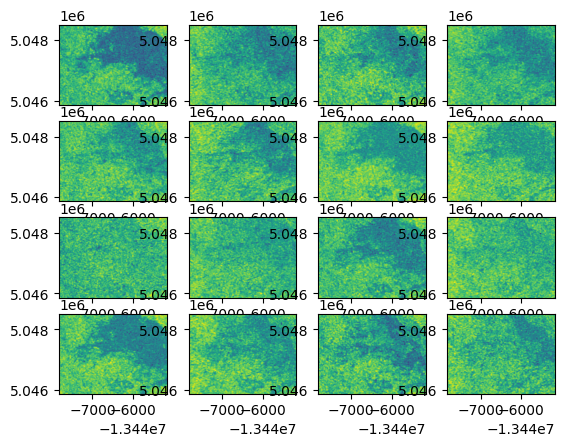

In [9]:
fig, axs = plt.subplots(4, 4)

image_list = all_images.toList(all_images.size())
for i in range(16): #all_images.size().getInfo()):
    image = ee.Image(image_list.get(i))
    image_tensor = torch.tensor(geemap.ee_to_numpy(image, region=point))
    
    if i % 10 == 0:
        print(i)
    image.geetools.plot(
       bands = [image.bandNames().getInfo()[1]],
       ax = axs[i//4, i%4],
       region=point,
       crs="EPSG:3857",
       scale=10,
       cmap="viridis",
       color="k"
    )

#plt.show()

In [5]:
#from PIL import Image
#from contextlib import contextmanager
#import os
#import gc

@contextmanager
def new_figure():
    fig, ax = plt.subplots()
    try:
        yield ax
    finally:
        plt.close(fig)
        del fig, ax
        gc.collect()

def create_png(ee_image, point,  name):
    with new_figure() as ax:
        ax.set_axis_off()
        ax.set_box_aspect(1)
        for i, band in enumerate(ee_image.bandNames().getInfo()[:-1]):
            ee_image.geetools.plot(
                bands = [band],
                ax = ax,
                region = point,
                crs = "EPSG:3857",
                scale = 10,
                cmap = ("Greens", "Blues")[i],
                color = "k"
            )
            fig.savefig(f'temp{i}{name}.png', bbox_inches="tight", pad_inches=0)

    with Image.open(f'temp0{name}.png') as im1, Image.open(f'temp1{name}.png') as im2:
        blended = Image.blend(im1, im2, alpha=.5)
        blended.save(f"images_snow_only/{name}.png")
        blended.close()

    for i in range(2):
        os.remove(f'temp{i}{name}.png')

    gc.collect()

#create_png(ee.Image(image_list.get(0)), point, "test")

In [6]:
def save_all_images(row):
    name = row.stationTriplet
    latitude = row.latitude
    longitude = row.longitude
    
    point = ee.Geometry.Point([longitude, latitude]).buffer(1000)
    collection = ee.ImageCollection(SENTINEL.filterBounds(point).filterDate(ee.Date('2022-01-01'), ee.Date('2024-12-31')))
    image_list = collection.toList(collection.size())

    for i in range(image_list.size().getInfo()):
        image = ee.Image(image_list.get(i))
        datestr = ee.Image(image_list.get(i)).date().format('yyyy-MM-dd').getInfo()
        
        if len(depth_df.loc[(depth_df['name'] == station) & (depth_df['date'] == datestr), "depth"].values) > 0:
            create_png(image, point, f"{name}_{datestr}")

        del image, datestr

In [7]:
from dask.distributed import WorkerPlugin

class EEInitializer(WorkerPlugin):
    def setup(self, worker):
        from geetools.ee_image import ImageAccessor
        self.worker = worker
        ee.Authenticate()
        ee.Initialize(project='ee-spencerscw-snow', opt_url='https://earthengine-highvolume.googleapis.com')

In [8]:
import dask.dataframe as dd
from dask.distributed import LocalCluster
cluster = LocalCluster(n_workers=64, threads_per_worker=1)
client = cluster.get_client()
client.register_plugin(EEInitializer())



{'tcp://127.0.0.1:32963': {'status': 'OK'},
 'tcp://127.0.0.1:33115': {'status': 'OK'},
 'tcp://127.0.0.1:33325': {'status': 'OK'},
 'tcp://127.0.0.1:33793': {'status': 'OK'},
 'tcp://127.0.0.1:33955': {'status': 'OK'},
 'tcp://127.0.0.1:33983': {'status': 'OK'},
 'tcp://127.0.0.1:34155': {'status': 'OK'},
 'tcp://127.0.0.1:34327': {'status': 'OK'},
 'tcp://127.0.0.1:34581': {'status': 'OK'},
 'tcp://127.0.0.1:34769': {'status': 'OK'},
 'tcp://127.0.0.1:34961': {'status': 'OK'},
 'tcp://127.0.0.1:35223': {'status': 'OK'},
 'tcp://127.0.0.1:35769': {'status': 'OK'},
 'tcp://127.0.0.1:36183': {'status': 'OK'},
 'tcp://127.0.0.1:36223': {'status': 'OK'},
 'tcp://127.0.0.1:36331': {'status': 'OK'},
 'tcp://127.0.0.1:36855': {'status': 'OK'},
 'tcp://127.0.0.1:36963': {'status': 'OK'},
 'tcp://127.0.0.1:37161': {'status': 'OK'},
 'tcp://127.0.0.1:37249': {'status': 'OK'},
 'tcp://127.0.0.1:37379': {'status': 'OK'},
 'tcp://127.0.0.1:37591': {'status': 'OK'},
 'tcp://127.0.0.1:37797': {'stat

In [10]:
station_info = dd.read_json('./stations.json', lines=True).repartition(npartitions=64)

#station_info_dd = dd.from_pandas(station_info, npartitions=64)

res = station_info.apply(save_all_images, axis=1, meta=pd.Series(dtype='object'))

In [9]:
cluster.dashboard_link

'http://127.0.0.1:8787/status'

In [0]:
res.compute()

/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 21.05 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


2025-04-21 12:49:22,554 - distributed.worker.memory - WARNING - Worker is at 89% memory usage. Pausing worker.  Process memory: 417.78 MiB -- Worker memory limit: 464.99 MiB
2025-04-21 12:49:22,554 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 417.78 MiB -- Worker memory limit: 464.99 MiB


2025-04-21 12:49:23,683 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:37253
Traceback (most recent call last):
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/worker.py", line 2075, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^

^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/worker.py", line 2878, in get_data_from_worker
    comm = await rpc.connect(worker)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/core.py", line 1485, in connect
    return await self._connect(addr=addr, timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/core.py", line 1429, in _connect
    comm = await connect(
           ^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/comm/core.py", line 377, in connect
    handshake = await comm.read()
                ^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/comm/tcp.py", l

cp://127.0.0.1:37253>: ConnectionResetError: [Errno 104] Connection reset by peer
2025-04-21 12:49:23,683 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:37253
Traceback (most recent call last):
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/worker.py", line 2075, in gather_dep

2025-04-21 12:49:27,360 - distributed.worker.memory - WARNING - Worker is at 90% memory usage. Pausing worker.  Process memory: 420.28 MiB -- Worker memory limit: 464.99 MiB
2025-04-21 12:49:27,360 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 420.28 MiB -- Worker memory limit: 464.99 MiB


2025-04-21 12:49:32,102 - distributed.worker.memory - WARNING - Worker is at 89% memory usage. Pausing worker.  Process memory: 417.35 MiB -- Worker memory limit: 464.99 MiB
2025-04-21 12:49:32,102 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 417.35 MiB -- Worker memory limit: 464.99 MiB


2025-04-21 12:49:33,408 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:46529
Traceback (most recent call last):
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/worker.py", line 2075, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^

2025-04-21 12:49:33,408 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:46529
Traceback (most recent call last):
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/worker.py", line 2075, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^

/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/worker.py", line 2878, in get_data_from_worker
    comm = await rpc.connect(worker)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/core.py", line 1485, in connect
    return await self._connect(addr=addr, timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/core.py", line 1429, in _connect
    comm = await connect(
           ^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/comm/core.py", line 377, in connect
    handshake = await comm.read()
                ^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/comm/tcp.py", line 237, in r

2025-04-21 12:49:37,221 - distributed.worker.memory - WARNING - Worker is at 89% memory usage. Pausing worker.  Process memory: 416.59 MiB -- Worker memory limit: 464.99 MiB
2025-04-21 12:49:37,222 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 416.59 MiB -- Worker memory limit: 464.99 MiB


2025-04-21 12:49:38,504 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:41715
Traceback (most recent call last):
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/worker.py", line 2075, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^

2025-04-21 12:49:38,504 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:41715
Traceback (most recent call last):
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/worker.py", line 2075, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^

2025-04-21 12:49:42,003 - distributed.worker.memory - WARNING - Worker is at 90% memory usage. Pausing worker.  Process memory: 419.03 MiB -- Worker memory limit: 464.99 MiB
2025-04-21 12:49:42,004 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 419.03 MiB -- Worker memory limit: 464.99 MiB


2025-04-21 12:49:43,127 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:36547
Traceback (most recent call last):
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/worker.py", line 2075, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^

e 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/worker.py", line 2075, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/worker.py", line 2878, in get_data_from_worker
    comm = await rpc.connect(worker)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositor

ceback (most recent call last):
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/worker.py", line 2075, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/worker.py", 

2025-04-21 12:49:46,314 - distributed.worker.memory - WARNING - Worker is at 90% memory usage. Pausing worker.  Process memory: 420.04 MiB -- Worker memory limit: 464.99 MiB
2025-04-21 12:49:46,315 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 420.04 MiB -- Worker memory limit: 464.99 MiB


2025-04-21 12:49:47,523 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:33549
Traceback (most recent call last):
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/worker.py", line 2075, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^

^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/worker.py", line 2878, in get_data_from_worker
    comm = await rpc.connect(worker)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/core.py", line 1485, in connect
    return await self._connect(addr=addr, timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/core.py", line 1429, in _connect
    comm = await connect(
           ^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/comm/core.py", line 377, in connect
    handshake = await comm.read()
                ^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/comm/tcp.py", l

e.py", line 1485, in connect
    return await self._connect(addr=addr, timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/core.py", line 1429, in _connect
    comm = await connect(
           ^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/comm/core.py", line 377, in connect
    handshake = await comm.read()
                ^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/comm/tcp.py", line 237, in read
    convert_stream_closed_error(self, e)
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/comm/tcp.py", line 143, in convert_stream_closed_error
    raise CommClosedError(f"in {obj}: {exc.__class__.__name__}: {exc}") from exc
distributed.comm.core.CommClosedError: 

distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:33549
Traceback (most recent call last):
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/worker.py", line 2075, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/skrewt/

2025-04-21 12:49:51,157 - distributed.worker.memory - WARNING - Worker is at 89% memory usage. Pausing worker.  Process memory: 415.32 MiB -- Worker memory limit: 464.99 MiB
2025-04-21 12:49:51,157 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 415.32 MiB -- Worker memory limit: 464.99 MiB


2025-04-21 12:49:52,408 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:35061
Traceback (most recent call last):
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/skrewt/Documents/Repositories/Snow_Sensing/.venv/lib/python3.12/site-packages/distributed/worker.py", line 2075, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^

In [12]:
from torch.utils.data import Dataset
from torchvision import transforms, utils, datasets

class SnowDataset(Dataset):
    def __init__(self, depth_df, size=224, train=True):
        self.depth_df = depth_df
        postfix = 'train' if train else 'test'
        self.dataset_folder = datasets.ImageFolder(
            'images_' + postfix,
            transform = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])
        )

    def __len__(self):
        return len(self.dataset_folder)

    def __getitem__(self, index):
        img = self.dataset_folder[index]
        station, date = self.dataset_folder.imgs[index][0].split('/')[2].strip('.png').split('_')
        
        try:
            depth = self.depth_df.loc[(self.depth_df['name'] == station) & (self.depth_df['date'] == date), "depth"].values[0]
        except:
            depth = 0

        return img[0], torch.tensor(depth)

In [8]:
ds = SnowDataset(depth_df)

depth_df.loc[(depth_df['name'] == "606:WA:SNTL") & (depth_df['date'] == "2022-03-26"), "depth"].values[0]

depth_df.loc["CO:SNOW" in depth_df['name']]

KeyError: 'False: boolean label can not be used without a boolean index'

In [14]:
from torch.utils.data import DataLoader

snow_dataloader = DataLoader(SnowDataset(depth_df), batch_size = 16, num_workers = 8)

"ab" in "arbc"

False

In [19]:
snow = iter(snow_dataloader)

for _ in range(100):
    imgs, depths = next(snow)
    print(depths)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([26, 32, 31, 30, 30, 31, 40, 29, 21, 20,  4,  0,  0,  0,  0,  0])
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  3, 23, 18, 25, 30, 32, 51, 48])
tensor([53, 53, 70, 75, 72, 96, 66, 58, 33,  0,  0,  0,  0,  0,  0,  0])
tensor([ 0,  0,  0,  0,  0,  0,  2,  0,  1,  9, 31, 24, 25, 54, 44, 47])
tensor([61, 64, 57, 56, 51, 26, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0])
tensor([ 0,  0,  0,  1,  3,  4, 10, 10, 20, 32, 21, 21, 22, 22, 26, 24])
tensor([28, 35, 44, 47, 42, 37, 34, 28, 24, 23, 15,  4,  0,  0,  0,  0])


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5])
tensor([ 4,  8,  6,  9, 10, 12, 12, 13, 16, 16, 21, 30, 26, 27, 40, 47])


tensor([46, 49, 45, 50, 48, 51, 54, 55, 53, 57, 58, 72, 78, 77, 72, 72])
tensor([73, 70, 74, 74, 71, 73, 70, 60, 57, 55, 52, 46, 41, 29, 14,  4])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 1, 1, 1, 2, 2, 2])


tensor([ 8,  8, 13, 10, 10, 10, 15, 14, 14, 19, 22, 30, 30, 28, 24, 23])
tensor([23, 33, 32, 41, 41, 40, 42, 43, 43, 59, 52, 48, 46, 49, 46, 42])
tensor([35, 31, 20, 15, 10,  4,  7,  2,  0,  0,  0,  0,  0,  0,  0,  0])


tensor([ 0,  0,  0,  0,  0, 19, 23, 20, 23, 24, 24, 23, 23, 23, 19, 17])
tensor([15, 11,  5,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11, 11, 11, 12, 16])
tensor([16, 15, 16, 10, 14, 11, 10, 18, 14, 13,  0,  0, 15, 14,  0,  0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 3, 3, 3, 3])


tensor([ 3,  3,  7,  8,  7,  6,  8,  8,  9,  8,  8,  8,  8, 11,  0, 19])


# Time Log:
## Research, data collection, API practice (total: 8.5 hours)
- 3/3 1.5 hours: Read docs for TorchGeo and Google Earth Engine
- 3/4 2.5 hours: Reread papers from my literature review to find in situ snow measurements
- 3/5 2 hours: Downloaded and cleaned the snow data
- 3/6 2.5 hours: Used Earth Engine API to download and display an S2 image for one target location

- 4/10 2 hours: Wrote the Dataset class and Dataloader to grab images dynamically from Earth Engine for the in-situ observations.
- 4/11 1.5 hours: More work on the dataloader and creating tensors from the images
- 4/12 2 hours: realized that downloading the images locally is nearly impossible after trying a lot of things
- 4/17 4.5 hours: worked on image preprocessing and pivoted to using matplotlib to save images
- 4/18 2 hours: selecting the best pretrained weights and model to use from TorchGeo, implementing a parallelizaiton scheme for the downloads using Dask
- 4/19 2 hours: Finished creating parallelizaiton, discovered that it leaks memory and I can't leave it overnight
- 4/20 2.5 hours: After running it repeatedly and starting to rebuild the Dataset class using the downloaded images, realized that most of my images were not snowy and therefore useless.
- 4/21 5 hours: Tried to rewrite downloading code to only include snowy images, but this was too  memory-intensive, so I tried to rewrite my Earth Engine query code, but then I wasn't able to download the images the same way anymore, so then I tried to convert them to a downloadable format, but ran out of time and made no further progress.